# ランダム回路

ランダムな回路を状態ベクトルシミュレータで実行して、CPU の場合と GPU の場合を比較します。

※ 環境によってどのくらいの量子ビット数で体感速度が向上するかは多少異なるので、お手元の PC などではまた違う結果になる可能性はあります。

謝辞: [WSL2 で cuQuantum (1)](https://zenn.dev/converghub/articles/73007f5e24f5fe) を参考にさせていただきました。

In [1]:
from qiskit import transpile, Aer
from qiskit.circuit.library import QuantumVolume

def experiment(qubits=21, device='CPU', cuStateVec_enable=False, return_circuit=False):
    backend = Aer.get_backend('aer_simulator_statevector')
    backend.set_options(device=device, cuStateVec_enable=cuStateVec_enable)

    qubits = qubits
    depth = 10
    shots = 10

    circuit = QuantumVolume(qubits, depth, seed=0)
    circuit.measure_all()
    if return_circuit:
        return circuit
    circuit = transpile(circuit, backend)
    result = backend.run(circuit, shots=shots, seed_simulator=12345).result()

    metadata = result.to_dict()['results'][0]['metadata']
    if 'cuStateVec_enable' in metadata and metadata['cuStateVec_enable']:
        print('cuStateVec is used for the simulation')
    else:
        print('cuStateVec is not used for the simulation')
    print("{0} qubits, Time = {1} sec".format(qubits,result.to_dict()['results'][0]['time_taken']))
    counts = result.get_counts()
    print(counts)

In [2]:
circuit = experiment(return_circuit=True)
circuit.decompose().draw(fold=-1)

┌──────────┐                                                            ┌──────────┐                                    ┌──────────┐                                                                      ┌──────────┐┌─────────┐                        ┌──────────┐                                                                                              ┌──────────┐┌──────────┐                                                                                                                                                ┌──────────┐                                                                                                            ░ ┌─┐                                                            
    q_0: ───────────────────────────────────────────────┤0         ├────────────────────────────────────────────────────────────┤0         ├────────────────────────────────────┤1         ├──────────────────────────────────────────────────────────────────────┤1         ├┤1        ├────────────────────────┤1         ├──────────────────────────────────────────────────────────────────────────────────────────────┤1         ├┤1         ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1         ├────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤M├────────────────────────────────────────────────────────────
                     ┌──────────┐                       │          │                                    ┌──────────┐            │          │                                    │          │┌─────────┐                        ┌──────────┐             ┌────────┐│          ││         │                        │          │          ┌──────────┐                                                                        │          ││          │                        ┌──────────┐                                    ┌──────────┐                                                ┌──────────┐│          │                        ┌──────────┐                                                                        ░ └╥┘┌─┐                                                         
    q_1: ────────────┤0         ├───────────────────────┤          ├────────────────────────────────────┤1         ├────────────┤          ├────────────────────────────────────┤          ├┤1        ├────────────────────────┤1         ├─────────────┤0       ├┤          ├┤  su4_29 ├────────────────────────┤          ├──────────┤1         ├────────────────────────────────────────────────────────────────────────┤          ├┤          ├────────────────────────┤0         ├────────────────────────────────────┤1         ├────────────────────────────────────────────────┤1         ├┤          ├────────────────────────┤1         ├────────────────────────────────────────────────────────────────────────░──╫─┤M├─────────────────────────────────────────────────────────
         ┌──────────┐│          │                       │          │            ┌──────────┐            │          │            │          │            ┌──────────┐            │          ││         │                        │          │┌──────────┐ │        ││          ││         │            ┌──────────┐│          │          │          │                                                                        │          ││          │                        │          │                        ┌──────────┐│          │                        ┌──────────┐┌──────────┐│          ││          │                        │          │            ┌─────────┐                                                 ░  ║ └╥┘┌─┐                                                      
    q_2: ┤0         ├┤          ├───────────────────────┤          ├────────────┤0         ├────────────┤          ├────────────┤          ├────────────┤1         ├────────────┤          ├┤         ├────────────────────────┤       

## CPU シミュレーション

In [3]:
experiment(device='CPU')

cuStateVec is not used for the simulation
21 qubits, Time = 11.284582508 sec
{'011001100010110110110': 1, '101100000011101101100': 1, '100011101111100011110': 1, '100100101011110001001': 1, '001101010001110001010': 1, '000001110011010101110': 1, '101100000001111100101': 1, '011101111011111110000': 1, '010110110101011111101': 1, '001101001111101001100': 1}


## GPU (cuQuantum) シミュレーション

In [4]:
experiment(device='GPU', cuStateVec_enable=True)

cuStateVec is used for the simulation
21 qubits, Time = 0.893104828 sec
{'011001100010110110110': 1, '101100000011101101100': 1, '100011101111100011110': 1, '100100101011110001001': 1, '001101010001110001010': 1, '000001110011010101110': 1, '101100000001111100101': 1, '011101111011111110000': 1, '010110110101011111101': 1, '001101001111101001100': 1}


＊＊＊＊＊

次はもう少し意味のあるアルゴリズムを試してみましょう。アルゴリズムの理論の紹介は今回はできませんが、量子回路の雰囲気だけは可視化できるようにしています。

# Grover のアルゴリズム

データベースの探索を行います。ここでは、金庫の暗証番号を想定しましょう。候補は 3 桁の 2 進数 '000', '001', '010', ..., '111' で、正解の暗証番号は 1 種類とします。オラクルと呼ばれる暗証番号入力機があるとします。あなたは手持ちの金庫の暗証番号を忘れてしまってしらみつぶしに試しますが、今回は量子計算を用いて効率的に暗証番号の解読を行います。

In [5]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, Aer
from qiskit_aer import AerSimulator
from qiskit.circuit.library import MCXGate
from qiskit.tools.visualization import plot_histogram

In [6]:
def revserse_phase(qc: QuantumCircuit, state: str):
    qubits = []
    for i, digit in enumerate(state[::-1]):
        if digit == '0':
            qubits.append(i)
    if qubits:
        qc.x(qubits)
    # MCZ start (HXH = Z)
    qc.h(n_qubits - 1)
    qc.append(MCXGate(n_qubits - 1), list(range(n_qubits)))
    qc.h(n_qubits - 1)
    # MCZ end
    if qubits:
        qc.x(qubits)

def define_oracle(solutions):
    # Create the oracle
    qreg = QuantumRegister(n_qubits, 'qr')
    oracle = QuantumCircuit(qreg)

    for sol in solutions:
        revserse_phase(oracle, sol)

    return oracle

def define_diffuser(n_qubits):
    qreg = QuantumRegister(n_qubits, 'qr')
    diffuser = QuantumCircuit(qreg)
    diffuser.h(qreg[:])
    diffuser.x(qreg[:])
    # MCZ start (HXH = Z)
    diffuser.h(qreg[n_qubits - 1])
    diffuser.append(MCXGate(n_qubits - 1), list(range(n_qubits)))
    diffuser.h(qreg[n_qubits - 1])
    # MCZ end
    diffuser.x(qreg[:])
    diffuser.h(qreg[:])

    return diffuser

以下の `solutions` が暗証番号です。適当に内容を変更しても問題ありません。あまりないかもしれませんが、複数の暗証番号がある・・・ということもあるかもしれません。

In [7]:
n_qubits = 15
# 以下を暗証番号とする。あなたは今日は忘れてしまっているが、以前これで暗証番号入力機を設定していた。
sol1 = bin(28053)[2:].zfill(n_qubits)
solutions = [sol1]

for sol in solutions:
    assert len(sol) == n_qubits, f'invalid solution length: {len(sol)} != {n_qubits}'
print(f'{solutions=}')

oracle = define_oracle(solutions)
oracle.draw(fold=-1)

solutions=['110110110010101']


qr_0: ───────■───────
       ┌───┐  │  ┌───┐
 qr_1: ┤ X ├──■──┤ X ├
       └───┘  │  └───┘
 qr_2: ───────■───────
       ┌───┐  │  ┌───┐
 qr_3: ┤ X ├──■──┤ X ├
       └───┘  │  └───┘
 qr_4: ───────■───────
       ┌───┐  │  ┌───┐
 qr_5: ┤ X ├──■──┤ X ├
       ├───┤  │  ├───┤
 qr_6: ┤ X ├──■──┤ X ├
       └───┘  │  └───┘
 qr_7: ───────■───────
              │       
 qr_8: ───────■───────
       ┌───┐  │  ┌───┐
 qr_9: ┤ X ├──■──┤ X ├
       └───┘  │  └───┘
qr_10: ───────■───────
              │       
qr_11: ───────■───────
       ┌───┐  │  ┌───┐
qr_12: ┤ X ├──■──┤ X ├
       └───┘  │  └───┘
qr_13: ───────■───────
       ┌───┐┌─┴─┐┌───┐
qr_14: ┤ H ├┤ X ├┤ H ├
       └───┘└───┘└───┘

In [8]:
diffuser = define_diffuser(n_qubits)
diffuser.draw(fold=-1)

┌───┐┌───┐          ┌───┐┌───┐     
 qr_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
       ├───┤├───┤       │  ├───┤├───┤     
 qr_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
       ├───┤├───┤       │  ├───┤├───┤     
 qr_2: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
       ├───┤├───┤       │  ├───┤├───┤     
 qr_3: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
       ├───┤├───┤       │  ├───┤├───┤     
 qr_4: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
       ├───┤├───┤       │  ├───┤├───┤     
 qr_5: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
       ├───┤├───┤       │  ├───┤├───┤     
 qr_6: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
       ├───┤├───┤       │  ├───┤├───┤     
 qr_7: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
       ├───┤├───┤       │  ├───┤├───┤     
 qr_8: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
       ├───┤├───┤       │  ├───┤├───┤     
 qr_9: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
       ├───┤├───┤       │  ├───┤├───┤     
qr_10: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
       ├───┤├───┤       │  ├───┤├───┤     
qr_11: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
       ├───┤├───┤       │  ├───┤├───┤     
qr_12: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
       ├───┤├───┤       │  ├───┤├───┤     
qr_13: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
       ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
qr_14: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
       └───┘└───┘└───┘└───┘└───┘└───┘└───┘

In [9]:
N = 2**n_qubits
angle = np.arcsin(np.sqrt(len(solutions) / N))
counts = int(np.round((np.pi/2 - angle) / (2*angle)))
print(f'{angle=}, {np.pi/2=}, {counts=}')

angle=0.005524299826304783, np.pi/2=1.5707963267948966, counts=142


In [10]:
qreg = QuantumRegister(n_qubits, 'qr')
grover = QuantumCircuit(qreg)
# initialize |s>
grover.h(qreg[:])
for _ in range(counts):
    grover = grover.compose(oracle)
    grover = grover.compose(diffuser)
grover.measure_all()
print(f'depth of the circuit: {grover.depth()}')
#grover.draw(fold=-1)

depth of the circuit: 1422


## CPU で解読

metadata['method']='statevector' metadata['device']='CPU' metadata['cuStateVec_enable']=False
{'110110110010101': 1024}


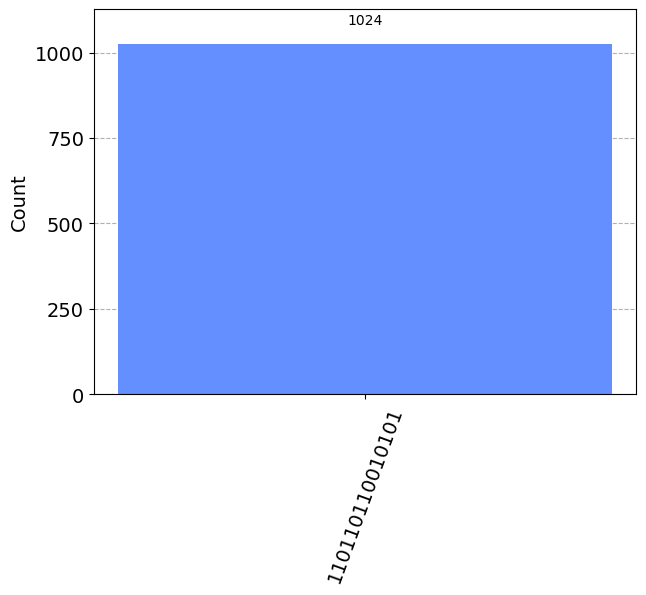

CPU times: user 28.6 s, sys: 23.4 s, total: 52 s
Wall time: 13.9 s


In [11]:
%%time
backend = Aer.get_backend('aer_simulator_statevector')
backend.set_options(seed_simulator=1234)

result = backend.run(grover).result()
metadata = result.results[0].metadata
print(f"{metadata['method']=} {metadata['device']=} {metadata['cuStateVec_enable']=}")
print(result.get_counts())
display(plot_histogram(result.get_counts()))

## GPU (cuQuantum) で解読

metadata['method']='statevector' metadata['device']='GPU' metadata['cuStateVec_enable']=True
{'110110110010101': 1024}


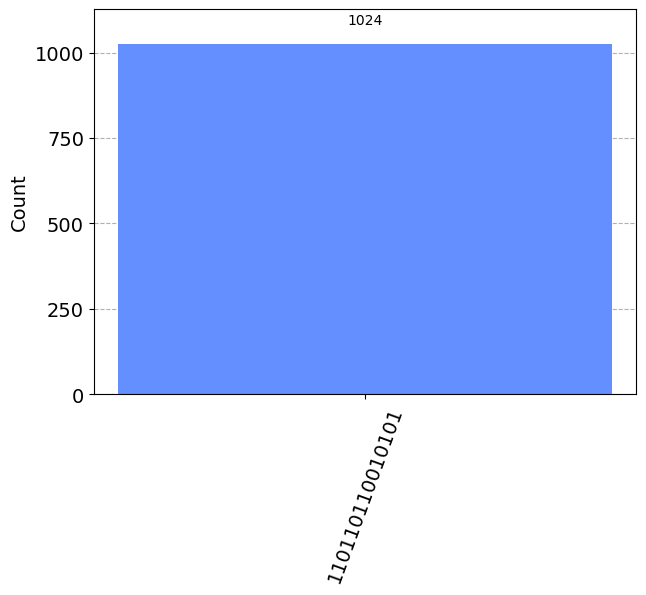

CPU times: user 755 ms, sys: 148 ms, total: 903 ms
Wall time: 682 ms


In [12]:
%%time
backend = Aer.get_backend('aer_simulator_statevector')
backend.set_options(device='GPU', cuStateVec_enable=True, seed_simulator=1234)

result = backend.run(grover).result()
metadata = result.results[0].metadata
print(f"{metadata['method']=} {metadata['device']=} {metadata['cuStateVec_enable']=}")
print(result.get_counts())
display(plot_histogram(result.get_counts()))

他にもシミュレータの種類がありますが、今回は状態ベクトルシミュレータというものを使う場合に GPU で高速化する方法を確認しました。